# DBSC Reproducibility Analysis

## Modules & Custom Functions

_The following cells must be run every time the notebook is restarted (up until `handle_session`)_

In [158]:
import itertools
from collections import defaultdict
from pathlib import Path

import dill
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from joblib import Parallel, delayed
from mne.viz import circular_layout
from mne_connectivity.viz import plot_connectivity_circle as plot_chord
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

# Set number of processors for multiprocessing
NPROC = 12

# Set maximum rows to display for pandas
pd.set_option("display.max_rows", None)

In [126]:
# Plot settings
# Color friendly color cycle - gist.github.com/thriveth/8560036
cb_color_cycle = [
    "#377eb8",
    "#ff7f00",
    "#4daf4a",
    "#f781bf",
    "#a65628",
    "#984ea3",
    "#999999",
    "#e41a1c",
    "#dede00",
]

cmap = mpl.cm.get_cmap("viridis")
cmap.set_bad("black")
sns.set(
    style="ticks",
    context="poster",
    rc={
        "image.cmap": "viridis",
        "axes.prop_cycle": plt.cycler(color=cb_color_cycle),
        "font.sans-serif": "Liberation Sans",
        "font.monospace": "Liberation Sans",
        "axes.titlesize": 16,
        "axes.titleweight": "bold",
        "axes.labelsize": 14,
        "axes.labelweight": "bold",
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
    },
)

boxprops = dict(edgecolor="white", alpha=0.5)
whiskerprops = dict(color="black", linestyle="--", alpha=0.5)
capprops = dict(color="black", alpha=0.5)
medianprops = dict(color="white", linewidth=2)
figure_dir = Path("./figures").resolve()
figure_dir.mkdir(parents=True, exist_ok=True)

In [2]:
def handle_session(db_file='dbsc_conn.db', save=False):
    # Database directory
    db_dir = Path("./.db").resolve()
    db_dir.mkdir(parents=True, exist_ok=True)
    
    if save:
        print("Saving notebook session...")
        dill.dump_session(db_dir.joinpath(db_file))
        print("Finished saving notebook session")
    else:
        print("Loading previous notebook session...")
        dill.load_session(db_dir.joinpath(db_file))
        print("Finished loading previous session!")
        
try:
    handle_session(db_file='dbsc-ohbm2023.db')
except:
    raise FileNotFoundError(
        """No previous session found - please run all of the following sells to setup
        custom functions and perform analysis."""
    )

Loading previous notebook session...
Finished loading previous session!


## Variables

In [3]:
db_file = 'dbsc-ohbm2023.db'

hcptest_dir = Path("../data/hcp_test").resolve()
snsx_dir = Path("../data/SNSX_7T").resolve()

## Functions

In [24]:
def find_missing_nodes(subject_labels, expected_labels):
    """Determine missing labels by comparing subject to expected"""
    missing_labels = expected_labels[~expected_labels['name'].isin(subject_labels['name'])]
    
    return missing_labels['index'].tolist()

In [310]:
def load_subject_conn(subject_weights, missing_nodes):
    """Load subject connectivity matrix, inserting missing, expected labels"""
    tmp_mat = np.genfromtxt(subject_weights, delimiter=",")
    
    # node - 1 for python indexing vs label index
    for node in missing_nodes:
        tmp_mat = np.insert(np.insert(tmp_mat, node-1, 0, axis=0), node-1, 0, axis=1)
    
    return tmp_mat[:, :, np.newaxis]

In [161]:
def check_hemi(node: int):
    """Determine hemispheric connectivity via label"""
    return "Even" if ((node % 2) == 0) else "Odd"

## Analysis

### Expected parcellation map

* `labelmerge` will output different tsvs per subject, depending on if label exists
* Generate an expected parcellation map for comparison

In [17]:
# BigBrain-Zona Parcels
bb_labels = pd.read_csv(
    hcptest_dir.joinpath("derivatives", "zona_bb_subcortex", "desc-ZonaBBSubcor_dseg.tsv"),
    delimiter="\t",
)
bb_labels['name'] = 'base ' + bb_labels['name']
# Freesurfer Thalamus parcels
fs_labels = pd.read_csv(
    hcptest_dir.joinpath("derivatives", "freesurferhcp", "desc-FreesurferThal_dseg.tsv"),
    delimiter="\t",
)
fs_labels['name'] = 'overlay ' + fs_labels['name']
fs_labels = fs_labels.sort_values(by="index")

# Expected parcels (reindexed)
expected_labels = pd.concat([bb_labels, fs_labels])
expected_labels = expected_labels.drop(columns="index")
expected_labels = expected_labels.reset_index(drop=True)
expected_labels['index'] = expected_labels.index + 1
del bb_labels, fs_labels

expected_labels.head(n=3)

,name,index
0,base Left RN,1
1,base Right RN,2
2,base Left SN,3


In [389]:
# Create copy for final parcels
final_labels = expected_labels.copy()

# # Drop hippocampus + non-motor, associative, and thalamic thalamus labels
hippo_labels = final_labels[final_labels["name"].str.contains("Hippocampus")]["index"].tolist()
final_labels = final_labels[~final_labels["index"].isin(hippo_labels)]

thal_labels = [26, 31, 32, 36, 43, 45, 46, 52, 57, 58, 62, 69, 71, 72]
keep_labels = list(range(1, 15)) + [19, 20] + thal_labels

keep_labels = final_labels[final_labels["index"].isin(keep_labels)]
left_labels = keep_labels[keep_labels['name'].str.contains('Left')]
right_labels = keep_labels[keep_labels['name'].str.contains('Right')]
left_labels = keep_labels[keep_labels['name'].str.contains('Left')]
sorted_keep_labels = pd.concat([left_labels, right_labels])

print(f"Final number of labels: {len(sorted_keep_labels)}\n")
sorted_keep_labels.head(n=3)

Final number of labels: 30



,name,index
0,base Left RN,1
2,base Left SN,3
4,base Left STn,5


### HCP Test (3T)

#### Demographics

In [20]:
# Load subject information
hcptest_demo_df = pd.read_csv(
    hcptest_dir.joinpath("bids", "participants.tsv"), 
    delimiter="\t",
    header=None
)
hcptest_demo_df = hcptest_demo_df.rename(columns = {0: "subject"})

# Subjects to drop
exclude_subj = ['sub-146129', 'sub-175439', 'sub-204521']
hcptest_demo_df = hcptest_demo_df[~hcptest_demo_df["subject"].isin(exclude_subj)]

handle_session(db_file=db_file, save=True)

print(f"Number of subjects: {len(hcptest_demo_df)}\n")
hcptest_demo_df.head(n=3)

Saving notebook session...
Finished saving notebook session
Number of subjects: 40



,subject
0,sub-103818
1,sub-105923
2,sub-111312


#### Subject connectivity

In [391]:
# Read in subject data
for sidx, subject in enumerate(tqdm(hcptest_demo_df['subject'].tolist())):
    subject_labels = pd.read_csv(
        hcptest_dir.joinpath("derivatives", "labelmerge", "combined", subject, f"{subject}_space-T1w_desc-combined_dseg.tsv"),
        delimiter="\t",
    )
    missing_nodes = find_missing_nodes(subject_labels, expected_labels)
    
    weights_file = hcptest_dir.joinpath("derivatives", "mrtrix", subject, "tractography", f"{subject}_desc-filteredsubcortical_nodeWeights.csv")
    if sidx == 0:
        hcptest_conn_mat = load_subject_conn(weights_file, missing_nodes)
    else:
        hcptest_conn_mat = np.append(
            hcptest_conn_mat, 
            load_subject_conn(weights_file, missing_nodes), 
            axis=2
    )

100%|███████████████████████████████████████████| 40/40 [00:09<00:00,  4.42it/s]


100%|███████████████████████████████████████████| 40/40 [00:13<00:00,  2.90it/s]


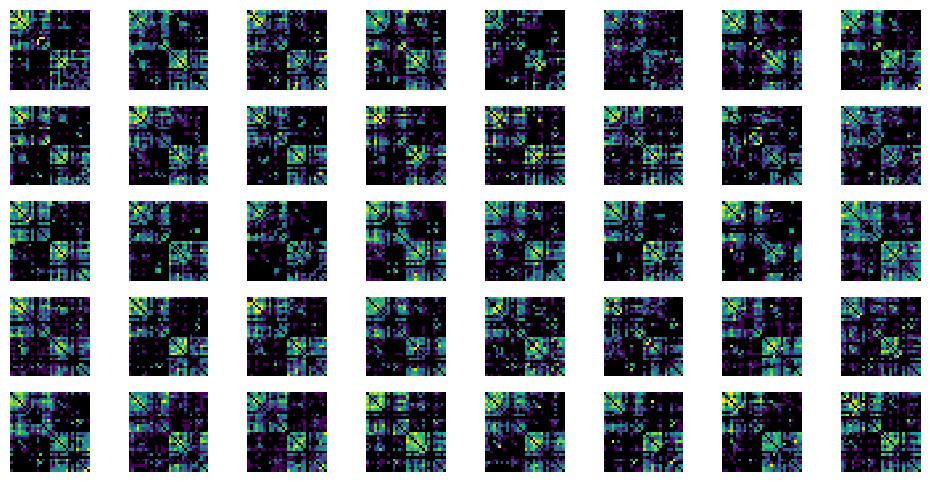

In [392]:
# Plot subject individual connectivity matrices 
f, ax = plt.subplots(5, 8, figsize=(12, 6))
for sidx in tqdm(range(len(hcptest_demo_df["subject"].tolist()))):
    df_hcptest_subj = pd.DataFrame(hcptest_conn_mat[:, :, sidx])
    df_hcptest_subj = df_hcptest_subj.filter(items=sorted_keep_labels.index, axis=0).filter(items=sorted_keep_labels.index, axis=1)

    # Plot
    sns.heatmap(
        np.log10(df_hcptest_subj),
        ax=ax[int(sidx / 8)][sidx % 8],
        cmap=cmap,
        vmin=-1,
        vmax=2,
        square=True,
        cbar=None,
    )

    ax[int(sidx / 8)][sidx % 8].tick_params(axis="both", length=0)
    ax[int(sidx / 8)][sidx % 8].set_xticklabels("", va="top", ha="center")
    ax[int(sidx / 8)][sidx % 8].set_yticklabels("", rotation=0, va="top", ha="right")

plt.show()
plt.close()

#### Group connectivity

In [393]:
# Compute average
hcptest_avgconn_mat = np.nanmean(hcptest_conn_mat, axis=2)
df_hcptest_avgconn = pd.DataFrame(hcptest_avgconn_mat)
df_hcptest_avgconn = df_hcptest_avgconn.filter(items=sorted_keep_labels.index, axis=0).filter(items=sorted_keep_labels.index, axis=1)

# Compute standard deviation
hcptest_stdconn_mat = np.nanstd(hcptest_conn_mat, axis=2)
df_hcptest_stdconn = pd.DataFrame(hcptest_stdconn_mat)
df_hcptest_stdconn = df_hcptest_stdconn.filter(items=sorted_keep_labels.index, axis=0).filter(items=sorted_keep_labels.index, axis=1)

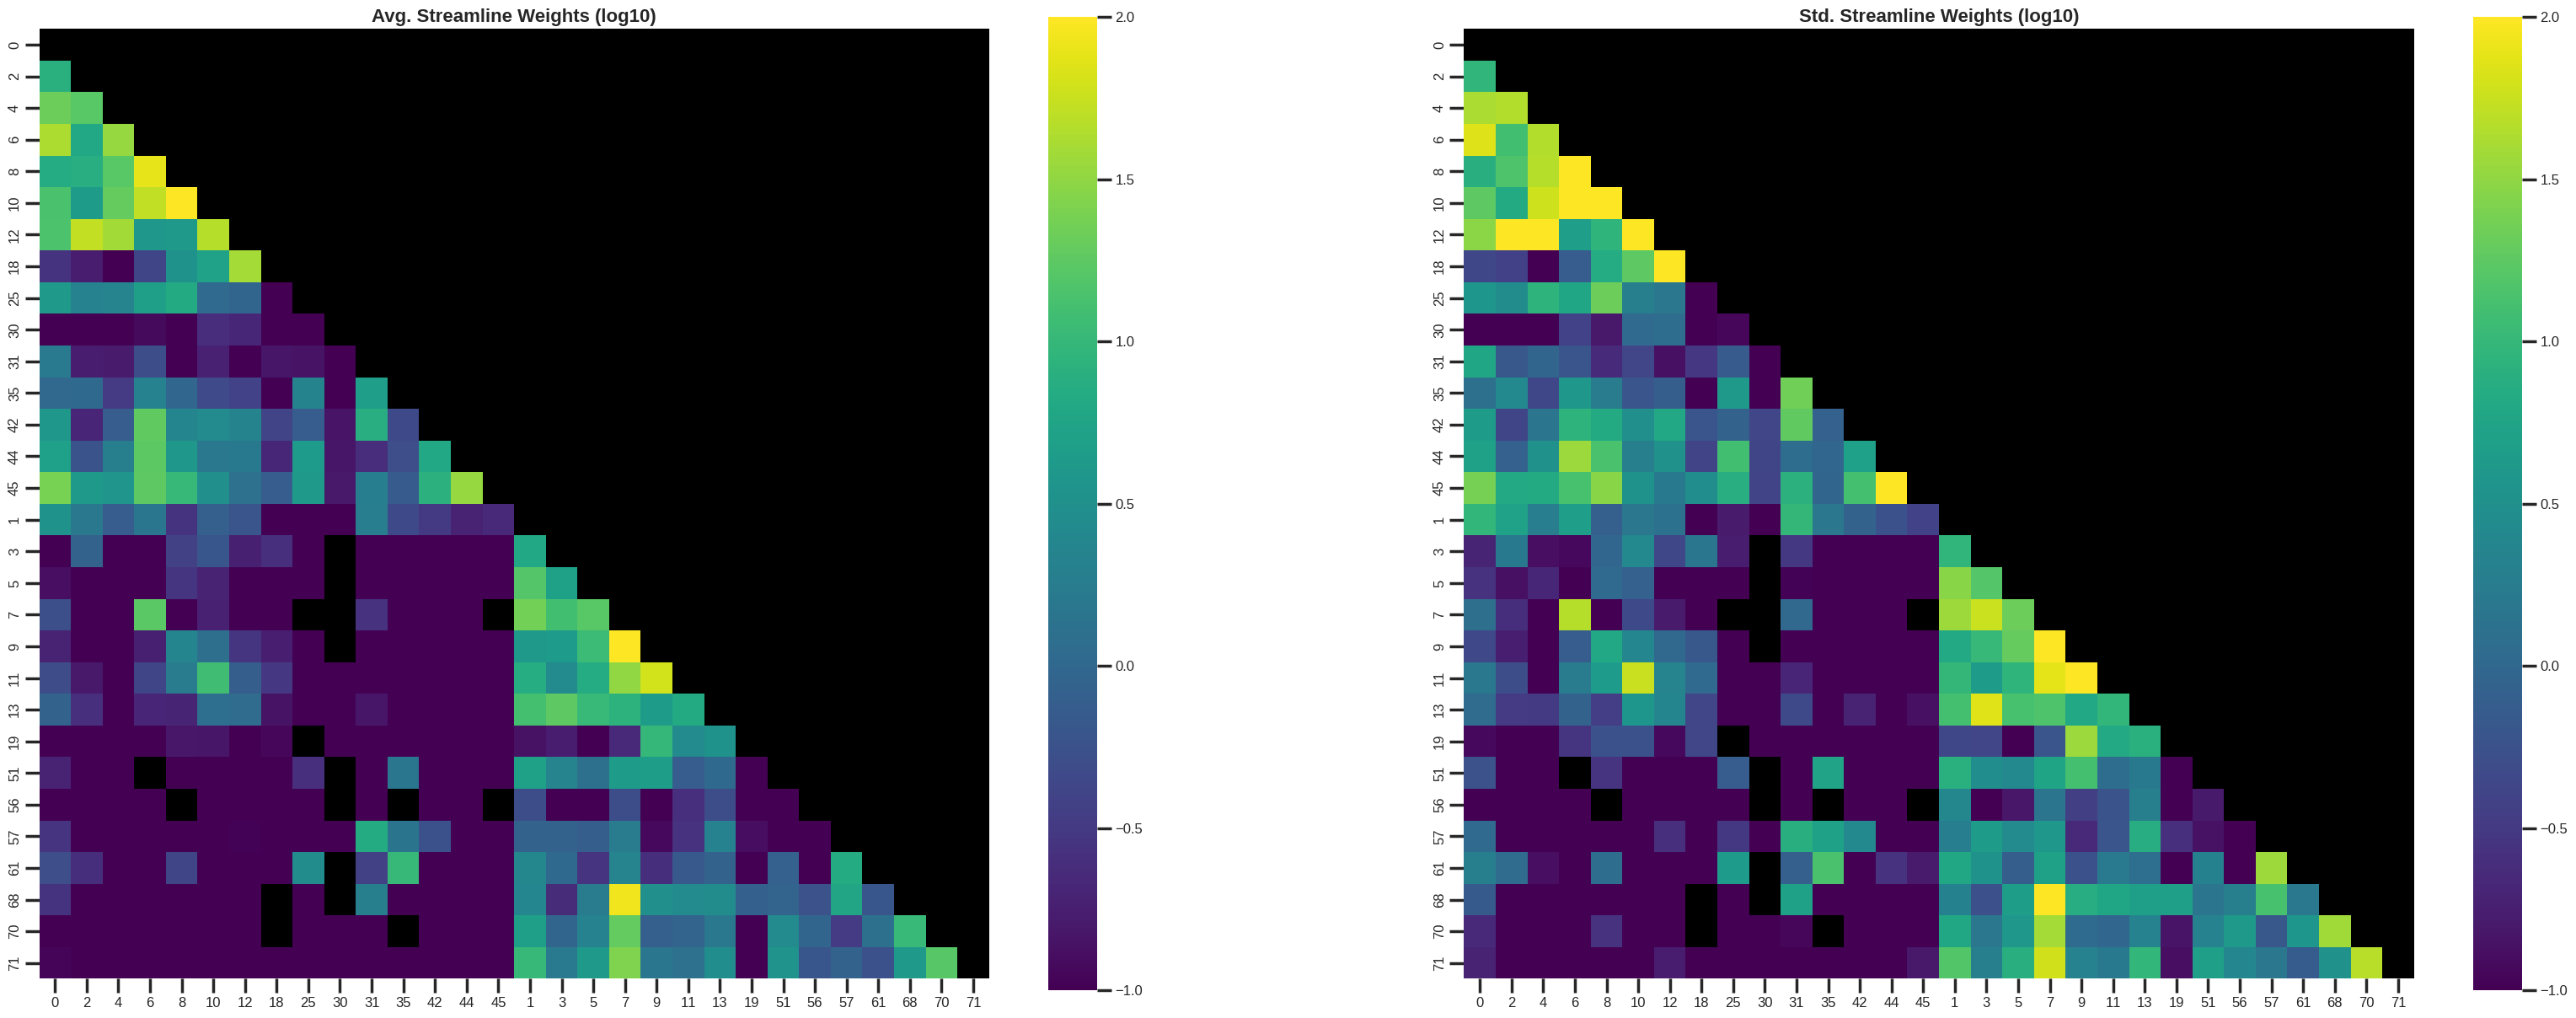

In [394]:
f, ax = plt.subplots(1, 2, figsize=(40, 15))

# Average
mask = np.triu(df_hcptest_avgconn)
sns.heatmap(
    np.log10(df_hcptest_avgconn),
    mask=mask,
    ax=ax[0],
    cmap=cmap,
    vmin=-1,
    vmax=2,
    square=True,
    # cbar_ax=cbar_ax1,
)
ax[0].set_title("Avg. Streamline Weights (log10)")

# Standard Deviation
mask = np.triu(df_hcptest_stdconn)
sns.heatmap(
    np.log10(df_hcptest_stdconn),
    mask=mask,
    ax=ax[1],
    cmap=cmap,
    vmin=-1,
    vmax=2,
    square=True,
)
ax[1].set_title("Std. Streamline Weights (log10)")


filename = "hcptest_group_conn.svg"
plt.savefig(figure_dir.joinpath(filename), dpi=300, bbox_inches="tight", facecolor="white")

plt.show()
plt.close()

##### Group connectivity dataframe

In [395]:
hcptest_conn_df = defaultdict(list)

for (node1, node2) in tqdm(list(itertools.combinations(sorted_keep_labels['index'].tolist(), 2))):
    nodes = f"{node1}-{node2}"
    
    # Check hemispheric connectivity
    if check_hemi(node1) == check_hemi(node2) == "Even":
        hemi = "R"
    elif check_hemi(node1) == check_hemi(node2) == "Odd":
        hemi = "L"
    else:
        hemi = "I"
        
    
    # Loop through subjects
    for sidx, subject in enumerate(hcptest_demo_df["subject"].tolist()):
        hcptest_conn_df["subject"].extend([subject])
        hcptest_conn_df["hemi"].extend([hemi])
        hcptest_conn_df["nodes"].extend([nodes])
        
        # Tract density
        df_hcptest_subj = pd.DataFrame(hcptest_conn_mat[:, :, sidx])
        tract_density = df_hcptest_subj.loc[node1 - 1, node2 - 1]
        hcptest_conn_df["tract density"].append(tract_density)
        hcptest_conn_df["tract density (log10)"].append(np.log10(tract_density))
        
del tract_density, hemi, nodes, df_hcptest_subj

hcptest_conn_df = pd.DataFrame(hcptest_conn_df)
handle_session(db_file=db_file, save=True)

hcptest_conn_df.head(n=3)

100%|████████████████████████████████████████| 435/435 [00:01<00:00, 263.82it/s]


Saving notebook session...
Finished saving notebook session


,subject,hemi,nodes,tract density,tract density (log10)
0,sub-103818,L,1-3,13.306373,1.124060
1,sub-105923,L,1-3,7.681631,0.885453
2,sub-111312,L,1-3,1.857048,0.268823


##### Motor Circuit

In [396]:
# Compute ROC curves
# Map nodes in left hemi (parc_map_idx, circuit_map_l_idx, circuit_map_r_idx
node_map = {"SN": (3, 0, 27), "STN": (5, 1, 26), "Caudate": (7, 2, 25), "Putamen": (9, 3, 24), 
            "GPe": (11, 4, 23), "GPi": (13, 5, 22), "Amygdala": (19, 6, 21), 
            "Thal CM": (26, 7, 20), "Thal VLa": (45, 8, 19), "Thal MDmc": (32, 9, 18), "Thal Pf": (36, 10, 17), 
            "Thal MDpc": (31, 11, 16), "Thal VA": (43, 12, 15), "Thal VLp": (46, 13, 14)}
l_node_names = [f"L {node}" for node in node_map.keys()]
r_node_names = [f"R {node}" for node in reversed(node_map.keys())]
final_node_names = l_node_names + r_node_names
del l_node_names, r_node_names


# TP connections 
motor_conn = ["SN-Putamen", "STN-GPe", "STN-GPi", "Putamen-GPe", "Putamen-GPi", "Putamen-Thal CM", "Putamen-Thal Pf", "GPi-Thal VLa", "GPi-Thal VLp"]
motor_idx = []
for conn in motor_conn:
    node1, node2 = conn.split("-")
    motor_idx.append((node_map[node1][1], node_map[node2][1]))
    motor_idx.append((node_map[node1][2], node_map[node2][2]))
del node1, node2
    
    
# Get connectivity of all motor network nodes
all_motor_l_conn, all_motor_r_conn = [], []
all_motor_l_idx, all_motor_r_idx = [], []
motor_all_nodes = ['SN', 'STN', 'Putamen', 'GPe', 'GPi', 'Thal CM', 'Thal VLa', 'Thal Pf', 'Thal VLp']
for conn in itertools.combinations(motor_all_nodes, 2):
    # Gap between left and right hemispheres for thalamus
    conn0_gap = 26 if "Thal" in conn[0] else 1
    conn1_gap = 26 if "Thal" in conn[1] else 1
    all_motor_l_conn.append(f"{str(node_map[conn[0]][0])}-{str(node_map[conn[1]][0])}")
    all_motor_l_idx.append((node_map[conn[0]][1], node_map[conn[1]][1]))
    all_motor_r_conn.append(f"{str(node_map[conn[0]][0]+conn0_gap)}-{str(node_map[conn[1]][0]+conn1_gap)}")
    all_motor_r_idx.append((node_map[conn[0]][2], node_map[conn[1]][2]))    
all_motor_conn = all_motor_l_conn + all_motor_r_conn
all_motor_idx = all_motor_l_idx + all_motor_r_idx
del conn0_gap, conn1_gap, all_motor_l_conn, all_motor_l_idx, all_motor_r_conn, all_motor_r_idx


# Get tract density
hcptest_motor_td = np.asarray(
    [hcptest_conn_df[hcptest_conn_df["nodes"] == node]["tract density"].mean() for node in all_motor_conn]
)

# Create all square matrix
hcptest_motortd_mat_fp = np.zeros((len(final_node_names), len(final_node_names)))
hcptest_motortd_mat_tp = hcptest_motortd_mat_fp.copy()
for j, idxes in enumerate(all_motor_idx):
    if idxes in motor_idx:
        hcptest_motortd_mat_tp[idxes[0], idxes[1]] = hcptest_motortd_mat_tp[idxes[1], idxes[0]] = np.log10(hcptest_motor_td[j])
    else:
        # Skip intrathalamic
        if (7 <= idxes[0] <= 13 and 7 <= idxes[1] <= 13) or (14 <= idxes[0] <= 20 and 14 <= idxes[1] <= 20):
            hcptest_motortd_mat_fp[idxes[0], idxes[1]] = hcptest_motortd_mat_fp[idxes[1], idxes[0]] = np.nan
        else:
            hcptest_motortd_mat_fp[idxes[0], idxes[1]] = hcptest_motortd_mat_fp[idxes[1], idxes[0]] = np.log10(hcptest_motor_td[j])

hcptest_motortd_mat_tp[hcptest_motortd_mat_tp == -np.inf] = np.nan
hcptest_motortd_mat_tp[hcptest_motortd_mat_tp == 0] = np.nan
hcptest_motortd_mat_fp[hcptest_motortd_mat_fp == -np.inf] = np.nan
hcptest_motortd_mat_fp[hcptest_motortd_mat_fp == 0] = np.nan

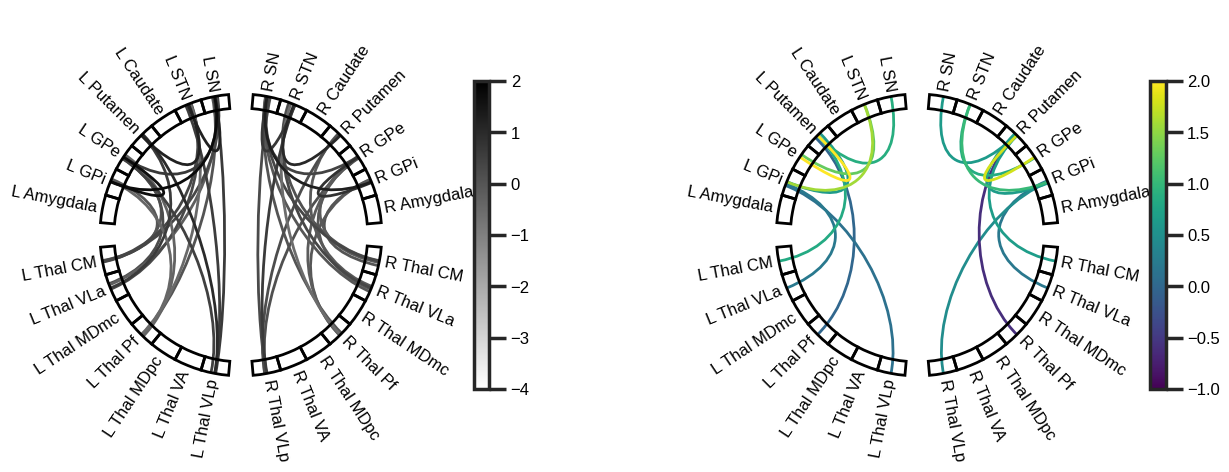

In [318]:
fig = plt.figure(figsize=(16, 8))

node_angles = circular_layout(final_node_names, final_node_names, start_pos=90,
                              group_boundaries=[0, 7, len(final_node_names) / 2, len(final_node_names) / 2 + 7])

# False connections
plot_chord(hcptest_motortd_mat_fp, 
           final_node_names,
           node_angles=node_angles,
           fig=fig,
           subplot=(1,2,1),
           colorbar_pos=(-0.3, 0.5), 
           colorbar_size=.5, 
           fontsize_colorbar=12, 
           fontsize_names=12, 
           colormap="binary",
           vmin=-4, vmax=2, 
           facecolor="white", 
           textcolor="black",
           node_colors=[(0,0,0,0)],
           linewidth=2,
           show=False)

# True connections
plot_chord(hcptest_motortd_mat_tp, 
           final_node_names,
           node_angles=node_angles,
           fig=fig, 
           subplot=(1,2,2),
           colorbar_pos=(-0.3, 0.5), 
           colorbar_size=.5, 
           fontsize_colorbar=12, 
           fontsize_names=12, 
           colormap=cmap,
           vmin=-1, vmax=2,
           facecolor="white", 
           textcolor="black",
           node_colors=[(0,0,0,0)],
           linewidth=2,
           show=False)

filename = "hcptest_group_motor_circuit.svg"
fig.savefig(figure_dir.joinpath(filename), dpi=300, bbox_inches="tight", facecolor="white")

plt.show()
plt.close()

##### Associative Circuit

In [338]:
# Compute ROC curves
# Map nodes in left hemi (parc_map_idx, circuit_map_l_idx, circuit_map_r_idx
node_map = {"SN": (3, 0, 27), "STN": (5, 1, 26), "Caudate": (7, 2, 25), "Putamen": (9, 3, 24), 
            "GPe": (11, 4, 23), "GPi": (13, 5, 22), "Amygdala": (19, 6, 21), 
            "Thal CM": (26, 7, 20), "Thal VLa": (45, 8, 19), "Thal MDmc": (32, 9, 18), "Thal Pf": (36, 10, 17), 
            "Thal MDpc": (31, 11, 16), "Thal VA": (43, 12, 15), "Thal VLp": (46, 13, 14)}
l_node_names = [f"L {node}" for node in node_map.keys()]
r_node_names = [f"R {node}" for node in reversed(node_map.keys())]
final_node_names = l_node_names + r_node_names
del l_node_names, r_node_names


# TP connections 
assoc_conn = ["STN-GPe", "STN-GPi", "Caudate-GPe", "Caudate-GPi", "Putamen-GPe", "GPe-GPi", "GPi-Thal VA"]
assoc_idx = []
for conn in assoc_conn:
    node1, node2 = conn.split("-")
    assoc_idx.append((node_map[node1][1], node_map[node2][1]))
    assoc_idx.append((node_map[node1][2], node_map[node2][2]))
del node1, node2

# Get connectivity of all associate network nodes
all_assoc_l_conn, all_assoc_r_conn = [], []
all_assoc_l_idx, all_assoc_r_idx = [], []
assoc_all_nodes = ['STN', 'Caudate', 'Putamen', 'GPe', 'GPi', 'Thal VA']
for conn in itertools.combinations(assoc_all_nodes, 2):
    # Gap between left and right hemispheres for thalamus
    conn0_gap = 26 if "Thal" in conn[0] else 1
    conn1_gap = 26 if "Thal" in conn[1] else 1
    all_assoc_l_conn.append(f"{str(node_map[conn[0]][0])}-{str(node_map[conn[1]][0])}")
    all_assoc_l_idx.append((node_map[conn[0]][1], node_map[conn[1]][1]))
    all_assoc_r_conn.append(f"{str(node_map[conn[0]][0]+conn0_gap)}-{str(node_map[conn[1]][0]+conn1_gap)}")
    all_assoc_r_idx.append((node_map[conn[0]][2], node_map[conn[1]][2]))
all_assoc_conn = all_assoc_l_conn + all_assoc_r_conn
all_assoc_idx = all_assoc_l_idx + all_assoc_r_idx
del conn0_gap, conn1_gap, all_assoc_l_conn, all_assoc_r_conn, all_assoc_l_idx, all_assoc_r_idx
    
# Get TDs
hcptest_assoc_td = np.asarray(
    [hcptest_conn_df[hcptest_conn_df["nodes"] == node]["tract density"].mean() for node in all_assoc_conn]
)

# Create all square matrix
hcptest_assoctd_mat_fp = np.zeros((len(final_node_names), len(final_node_names)))
hcptest_assoctd_mat_tp = hcptest_assoctd_mat_fp.copy()
for j, idxes in enumerate(all_assoc_idx):
    if idxes in assoc_idx:
        hcptest_assoctd_mat_tp[idxes[0], idxes[1]] = hcptest_assoctd_mat_tp[idxes[1], idxes[0]] = np.log10(hcptest_assoc_td[j])
    else:
        # Skip intrathalamic
        if (7 <= idxes[0] <= 13 and 7 <= idxes[1] <= 13) or (14 <= idxes[0] <= 20 and 14 <= idxes[1] <= 20):
            hcptest_assoctd_mat_fp[idxes[0], idxes[1]] = hcptest_assoctd_mat_fp[idxes[1], idxes[0]] = np.nan
        else:
            hcptest_assoctd_mat_fp[idxes[0], idxes[1]] = hcptest_assoctd_mat_fp[idxes[1], idxes[0]] = np.log10(hcptest_assoc_td[j])

hcptest_assoctd_mat_tp[hcptest_assoctd_mat_tp == -np.inf] = np.nan
hcptest_assoctd_mat_tp[hcptest_assoctd_mat_tp == 0] = np.nan
hcptest_assoctd_mat_fp[hcptest_assoctd_mat_fp == -np.inf] = np.nan
hcptest_assoctd_mat_fp[hcptest_assoctd_mat_fp == 0] = np.nan

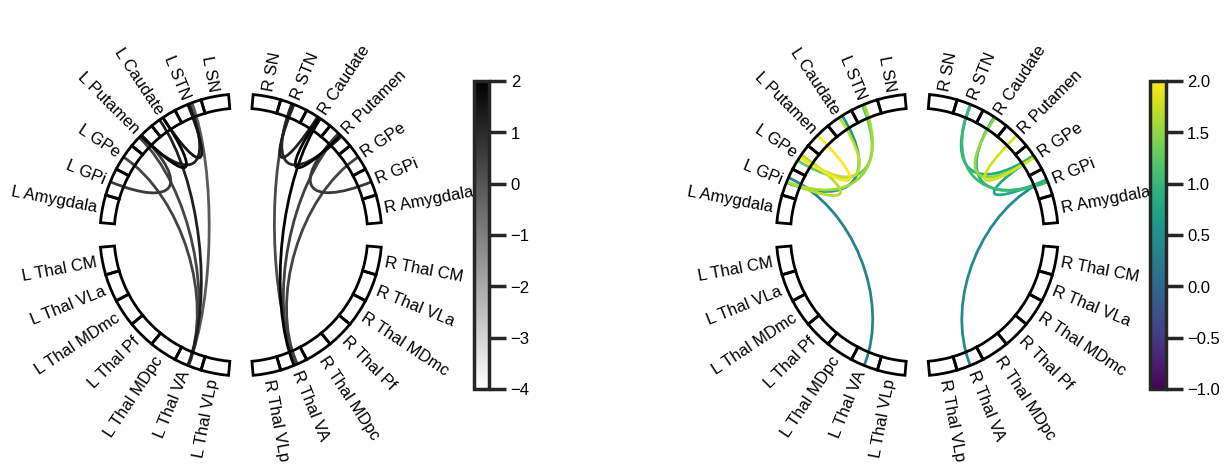

In [339]:
fig = plt.figure(figsize=(16, 8))

node_angles = circular_layout(final_node_names, final_node_names, start_pos=90,
                              group_boundaries=[0, 7, len(final_node_names) / 2, len(final_node_names) / 2 + 7])

# False connections
plot_chord(hcptest_assoctd_mat_fp, 
           final_node_names,
           node_angles=node_angles,
           fig=fig,
           subplot=(1,2,1),
           colorbar_pos=(-0.3, 0.5), 
           colorbar_size=.5, 
           fontsize_colorbar=12, 
           fontsize_names=12, 
           colormap="binary",
           vmin=-4, vmax=2, 
           facecolor="white", 
           textcolor="black",
           node_colors=[(0,0,0,0)],
           linewidth=2,
           show=False)

# True connections
plot_chord(hcptest_assoctd_mat_tp, 
           final_node_names,
           node_angles=node_angles,
           fig=fig, 
           subplot=(1,2,2),
           colorbar_pos=(-0.3, 0.5), 
           colorbar_size=.5, 
           fontsize_colorbar=12, 
           fontsize_names=12, 
           colormap=cmap,
           vmin=-1, vmax=2,
           facecolor="white", 
           textcolor="black",
           node_colors=[(0,0,0,0)],
           linewidth=2,
           show=False)

filename = "hcptest_group_assoc_circuit.svg"
fig.savefig(figure_dir.joinpath(filename), dpi=300, bbox_inches="tight", facecolor="white")

plt.show()
plt.close()

##### Limbic Circuit

In [340]:
# Compute ROC curves
# Map nodes in left hemi (parc_map_idx, circuit_map_l_idx, circuit_map_r_idx
node_map = {"SN": (3, 0, 27), "STN": (5, 1, 26), "Caudate": (7, 2, 25), "Putamen": (9, 3, 24), 
            "GPe": (11, 4, 23), "GPi": (13, 5, 22), "Amygdala": (19, 6, 21), 
            "Thal CM": (26, 7, 20), "Thal VLa": (45, 8, 19), "Thal MDmc": (32, 9, 18), "Thal Pf": (36, 10, 17), 
            "Thal MDpc": (31, 11, 16), "Thal VA": (43, 12, 15), "Thal VLp": (46, 13, 14)}
l_node_names = [f"L {node}" for node in node_map.keys()]
r_node_names = [f"R {node}" for node in reversed(node_map.keys())]
final_node_names = l_node_names + r_node_names
del l_node_names, r_node_names


# TP connections 
limbic_conn = ["STN-GPe", "STN-GPi", "Caudate-Amygdala", "Putamen-GPi", "Putamen-Amygdala", "GPi-Thal MDmc", "GPi-Thal MDpc"]
limbic_idx = []
for conn in limbic_conn:
    node1, node2 = conn.split("-")
    limbic_idx.append((node_map[node1][1], node_map[node2][1]))
    limbic_idx.append((node_map[node1][2], node_map[node2][2]))
del node1, node2

# Get connectivity of all limbic network nodes
all_limbic_l_conn, all_limbic_r_conn = [], []
all_limbic_l_idx, all_limbic_r_idx = [], []
limbic_all_nodes = ['STN', 'Caudate', 'Putamen', 'GPe', 'GPi', 'Amygdala', 'Thal MDmc', 'Thal MDpc']
for conn in itertools.combinations(limbic_all_nodes, 2):
    conn0_gap = 26 if "Thal" in conn[0] else 1
    conn1_gap = 26 if "Thal" in conn[1] else 1
    all_limbic_l_conn.append(f"{str(node_map[conn[0]][0])}-{str(node_map[conn[1]][0])}")
    all_limbic_l_idx.append((node_map[conn[0]][1], node_map[conn[1]][1]))
    all_limbic_r_conn.append(f"{str(node_map[conn[0]][0]+conn0_gap)}-{str(node_map[conn[1]][0]+conn1_gap)}")
    all_limbic_r_idx.append((node_map[conn[0]][2], node_map[conn[1]][2]))
all_limbic_conn = all_limbic_l_conn + all_limbic_r_conn
all_limbic_idx = all_limbic_l_idx + all_limbic_r_idx
del conn0_gap, conn1_gap, all_limbic_l_conn, all_limbic_r_conn, all_limbic_l_idx, all_limbic_r_idx
    
# Get TDs
hcptest_limbic_td = np.asarray(
    [hcptest_conn_df[hcptest_conn_df["nodes"] == node]["tract density"].mean() for node in all_limbic_conn]
)

# Create all square matrix
hcptest_limbictd_mat_fp = np.zeros((len(final_node_names), len(final_node_names)))
hcptest_limbictd_mat_tp = hcptest_limbictd_mat_fp.copy()
for j, idxes in enumerate(all_limbic_idx):
    if idxes in limbic_idx:
        hcptest_limbictd_mat_tp[idxes[0], idxes[1]] = hcptest_limbictd_mat_tp[idxes[1], idxes[0]] = np.log10(hcptest_limbic_td[j])
    else:
        # Skip intrathalamic
        if (7 <= idxes[0] <= 13 and 7 <= idxes[1] <= 13) or (14 <= idxes[0] <= 20 and 14 <= idxes[1] <= 20):
            hcptest_limbictd_mat_fp[idxes[0], idxes[1]] = hcptest_limbictd_mat_fp[idxes[1], idxes[0]] = np.nan
        else:
            hcptest_limbictd_mat_fp[idxes[0], idxes[1]] = hcptest_limbictd_mat_fp[idxes[1], idxes[0]] = np.log10(hcptest_limbic_td[j])

hcptest_limbictd_mat_tp[hcptest_limbictd_mat_tp == -np.inf] = np.nan
hcptest_limbictd_mat_tp[hcptest_limbictd_mat_tp == 0] = np.nan
hcptest_limbictd_mat_fp[hcptest_limbictd_mat_fp == -np.inf] = np.nan
hcptest_limbictd_mat_fp[hcptest_limbictd_mat_fp == 0] = np.nan

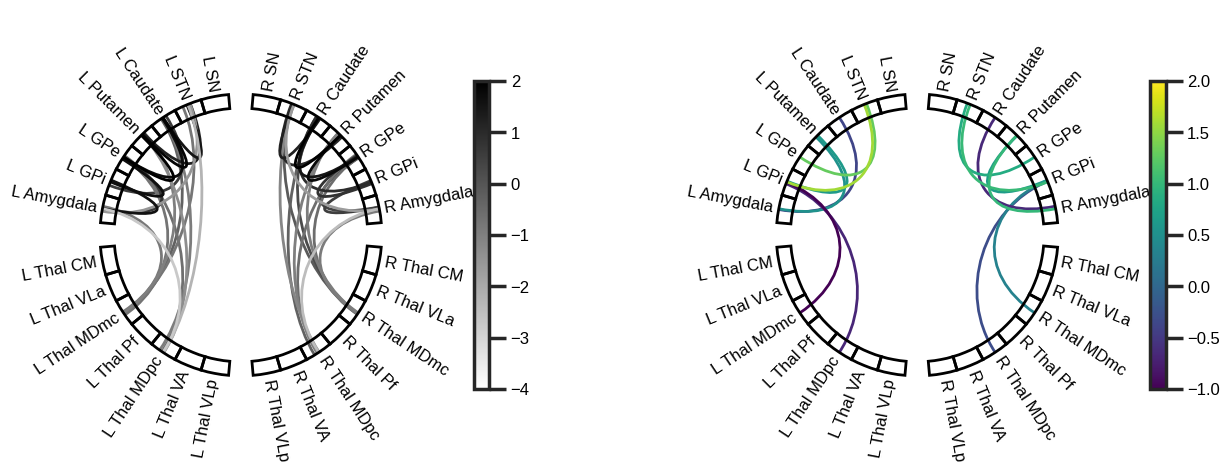

In [341]:
fig = plt.figure(figsize=(16, 8))

node_angles = circular_layout(final_node_names, final_node_names, start_pos=90,
                              group_boundaries=[0, 7, len(final_node_names) / 2, len(final_node_names) / 2 + 7])

# False connections
plot_chord(hcptest_limbictd_mat_fp, 
           final_node_names,
           node_angles=node_angles,
           fig=fig,
           subplot=(1,2,1),
           colorbar_pos=(-0.3, 0.5), 
           colorbar_size=.5, 
           fontsize_colorbar=12, 
           fontsize_names=12, 
           colormap="binary",
           vmin=-4, vmax=2, 
           facecolor="white", 
           textcolor="black",
           node_colors=[(0,0,0,0)],
           linewidth=2,
           show=False)

# True connections
plot_chord(hcptest_limbictd_mat_tp, 
           final_node_names,
           node_angles=node_angles,
           fig=fig, 
           subplot=(1,2,2),
           colorbar_pos=(-0.3, 0.5), 
           colorbar_size=.5, 
           fontsize_colorbar=12, 
           fontsize_names=12, 
           colormap=cmap,
           vmin=-1, vmax=2,
           facecolor="white", 
           textcolor="black",
           node_colors=[(0,0,0,0)],
           linewidth=2,
           show=False)

filename = "hcptest_group_limbic_circuit.svg"
fig.savefig(figure_dir.joinpath(filename), dpi=300, bbox_inches="tight", facecolor="white")

plt.show()
plt.close()

### SNSX Controls (7T)

#### Demographics

In [344]:
# Load subject information
snsx_demo_df = pd.read_csv(
    snsx_dir.joinpath("bids", "participants.tsv"), 
    delimiter="\t",
)
snsx_demo_df = snsx_demo_df.rename(columns = {"participant_id": "subject"})

# Subjects to drop
exclude_subj = ['sub-C014', 'sub-C028']
snsx_demo_df = snsx_demo_df[~snsx_demo_df["subject"].isin(exclude_subj)]

# handle_session(db_file=db_file, save=True)

print(f"Number of subjects: {len(snsx_demo_df)}\n")
snsx_demo_df.head(n=3)

Number of subjects: 34



,subject
0,sub-C001
1,sub-C002
2,sub-C003


#### Subject connectivity

In [400]:
# Read in subject data
for sidx, subject in enumerate(tqdm(snsx_demo_df['subject'].tolist())):
    subject_labels = pd.read_csv(
        snsx_dir.joinpath("derivatives", "labelmerge", "combined", subject, f"{subject}_space-T1w_desc-combined_dseg.tsv"),
        delimiter="\t",
    )
    missing_nodes = find_missing_nodes(subject_labels, expected_labels)
    
    weights_file = snsx_dir.joinpath("derivatives", "mrtrix", subject, "tractography", f"{subject}_desc-filteredsubcortical_nodeWeights.csv")
    if sidx == 0:
        snsx_conn_mat = load_subject_conn(weights_file, missing_nodes)
    else:
        snsx_conn_mat = np.append(
            snsx_conn_mat, 
            load_subject_conn(weights_file, missing_nodes), 
            axis=2
    )

100%|███████████████████████████████████████████| 34/34 [00:03<00:00, 10.98it/s]


100%|███████████████████████████████████████████| 34/34 [00:12<00:00,  2.74it/s]


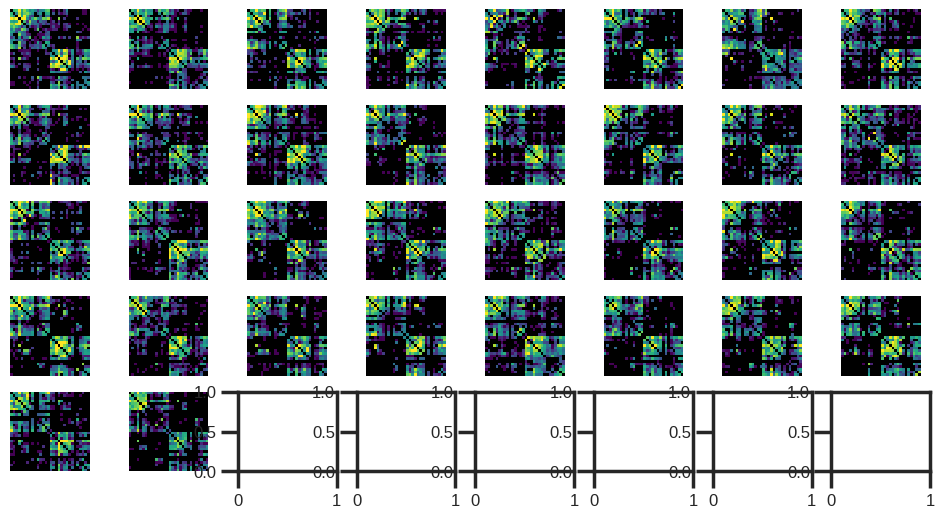

In [401]:
# Plot subject individual connectivity matrices 
f, ax = plt.subplots(5, 8, figsize=(12, 6))
for sidx in tqdm(range(len(snsx_demo_df["subject"].tolist()))):
    df_snsx_subj = pd.DataFrame(snsx_conn_mat[:, :, sidx])
    df_snsx_subj = df_snsx_subj.filter(items=sorted_keep_labels.index, axis=0).filter(items=sorted_keep_labels.index, axis=1)

    # Plot
    sns.heatmap(
        np.log10(df_snsx_subj),
        ax=ax[int(sidx / 8)][sidx % 8],
        cmap=cmap,
        vmin=-1,
        vmax=2,
        square=True,
        cbar=None,
    )

    ax[int(sidx / 8)][sidx % 8].tick_params(axis="both", length=0)
    ax[int(sidx / 8)][sidx % 8].set_xticklabels("", va="top", ha="center")
    ax[int(sidx / 8)][sidx % 8].set_yticklabels("", rotation=0, va="top", ha="right")

plt.show()
plt.close()

#### Group connectivity

In [402]:
# Compute average
snsx_avgconn_mat = np.nanmean(snsx_conn_mat, axis=2)
df_snsx_avgconn = pd.DataFrame(snsx_avgconn_mat)
df_snsx_avgconn = df_snsx_avgconn.filter(items=sorted_keep_labels.index, axis=0).filter(items=sorted_keep_labels.index, axis=1)

# Compute standard deviation
snsx_stdconn_mat = np.nanstd(snsx_conn_mat, axis=2)
df_snsx_stdconn = pd.DataFrame(snsx_stdconn_mat)
df_snsx_stdconn = df_snsx_stdconn.filter(items=sorted_keep_labels.index, axis=0).filter(items=sorted_keep_labels.index, axis=1)

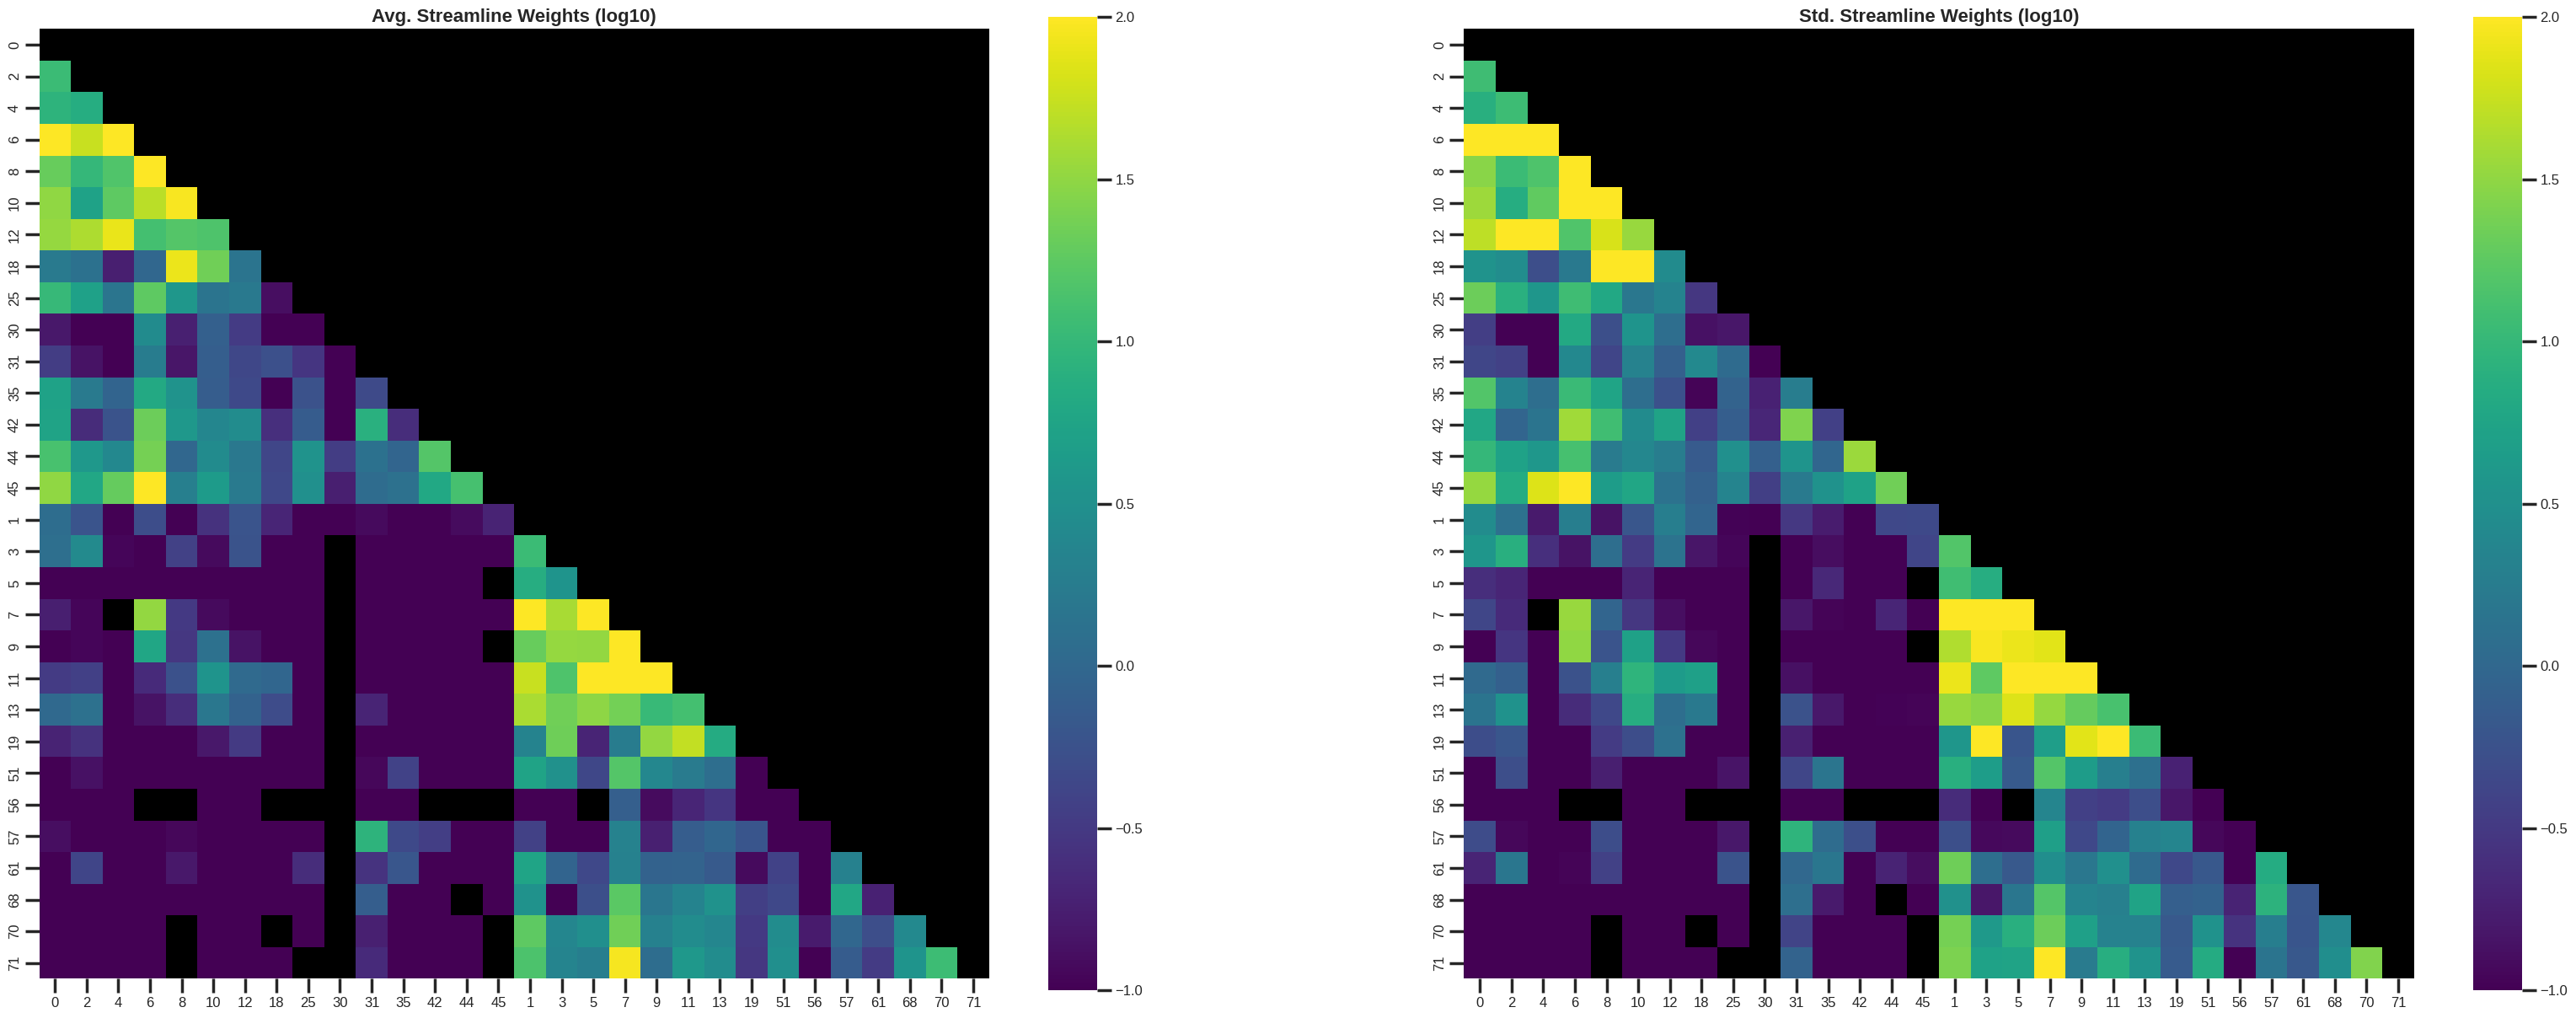

In [403]:
f, ax = plt.subplots(1, 2, figsize=(40, 15))

# Average
mask = np.triu(df_snsx_avgconn)
sns.heatmap(
    np.log10(df_snsx_avgconn),
    mask=mask,
    ax=ax[0],
    cmap=cmap,
    vmin=-1,
    vmax=2,
    square=True,
    # cbar_ax=cbar_ax1,
)
ax[0].set_title("Avg. Streamline Weights (log10)")

# Standard Deviation
mask = np.triu(df_snsx_stdconn)
sns.heatmap(
    np.log10(df_snsx_stdconn),
    mask=mask,
    ax=ax[1],
    cmap=cmap,
    vmin=-1,
    vmax=2,
    square=True,
)
ax[1].set_title("Std. Streamline Weights (log10)")


filename = "snsx_group_conn.svg"
plt.savefig(figure_dir.joinpath(filename), dpi=300, bbox_inches="tight", facecolor="white")

plt.show()
plt.close()

##### Group connectivity dataframe

In [404]:
snsx_conn_df = defaultdict(list)

for (node1, node2) in tqdm(list(itertools.combinations(sorted_keep_labels['index'].tolist(), 2))):
    nodes = f"{node1}-{node2}"
    
    # Check hemispheric connectivity
    if check_hemi(node1) == check_hemi(node2) == "Even":
        hemi = "R"
    elif check_hemi(node1) == check_hemi(node2) == "Odd":
        hemi = "L"
    else:
        hemi = "I"
        
    
    # Loop through subjects
    for sidx, subject in enumerate(snsx_demo_df["subject"].tolist()):
        snsx_conn_df["subject"].extend([subject])
        snsx_conn_df["hemi"].extend([hemi])
        snsx_conn_df["nodes"].extend([nodes])
        
        # Tract density
        df_snsx_subj = pd.DataFrame(snsx_conn_mat[:, :, sidx])
        tract_density = df_snsx_subj.loc[node1 - 1, node2 - 1]
        snsx_conn_df["tract density"].append(tract_density)
        snsx_conn_df["tract density (log10)"].append(np.log10(tract_density))
        
del tract_density, hemi, nodes, df_snsx_subj

snsx_conn_df = pd.DataFrame(snsx_conn_df)
handle_session(db_file=db_file, save=True)

snsx_conn_df.head(n=3)

100%|████████████████████████████████████████| 435/435 [00:01<00:00, 309.07it/s]


Saving notebook session...
Finished saving notebook session


,subject,hemi,nodes,tract density,tract density (log10)
0,sub-C001,L,1-3,9.090673,0.958596
1,sub-C002,L,1-3,11.717775,1.068845
2,sub-C003,L,1-3,9.446603,0.975276


In [425]:
snsx_conn_df[snsx_conn_df["nodes"]=="13-45"]

,subject,hemi,nodes,tract density,tract density (log10)
5610,sub-C001,L,13-45,0.000000,-inf
5611,sub-C002,L,13-45,1.858332,0.269123
5612,sub-C003,L,13-45,2.796274,0.446580
5613,sub-C004,L,13-45,0.625837,-0.203539
5614,sub-C005,L,13-45,0.078730,-1.103861
5615,sub-C006,L,13-45,1.391686,0.143541
5616,sub-C007,L,13-45,1.563179,0.194009
5617,sub-C008,L,13-45,0.296880,-0.527418
5618,sub-C009,L,13-45,9.652345,0.984633
5619,sub-C010,L,13-45,0.363177,-0.439882


##### Motor Circuit

In [354]:
# Compute ROC curves
# Map nodes in left hemi (parc_map_idx, circuit_map_l_idx, circuit_map_r_idx
node_map = {"SN": (3, 0, 27), "STN": (5, 1, 26), "Caudate": (7, 2, 25), "Putamen": (9, 3, 24), 
            "GPe": (11, 4, 23), "GPi": (13, 5, 22), "Amygdala": (19, 6, 21), 
            "Thal CM": (26, 7, 20), "Thal VLa": (45, 8, 19), "Thal MDmc": (32, 9, 18), "Thal Pf": (36, 10, 17), 
            "Thal MDpc": (31, 11, 16), "Thal VA": (43, 12, 15), "Thal VLp": (46, 13, 14)}
l_node_names = [f"L {node}" for node in node_map.keys()]
r_node_names = [f"R {node}" for node in reversed(node_map.keys())]
final_node_names = l_node_names + r_node_names
del l_node_names, r_node_names


# TP connections 
motor_conn = ["SN-Putamen", "STN-GPe", "STN-GPi", "Putamen-GPe", "Putamen-GPi", "Putamen-Thal CM", "Putamen-Thal Pf", "GPi-Thal VLa", "GPi-Thal VLp"]
motor_idx = []
for conn in motor_conn:
    node1, node2 = conn.split("-")
    motor_idx.append((node_map[node1][1], node_map[node2][1]))
    motor_idx.append((node_map[node1][2], node_map[node2][2]))
del node1, node2
    
    
# Get connectivity of all motor network nodes
all_motor_l_conn, all_motor_r_conn = [], []
all_motor_l_idx, all_motor_r_idx = [], []
motor_all_nodes = ['SN', 'STN', 'Putamen', 'GPe', 'GPi', 'Thal CM', 'Thal VLa', 'Thal Pf', 'Thal VLp']
for conn in itertools.combinations(motor_all_nodes, 2):
    # Gap between left and right hemispheres for thalamus
    conn0_gap = 26 if "Thal" in conn[0] else 1
    conn1_gap = 26 if "Thal" in conn[1] else 1
    all_motor_l_conn.append(f"{str(node_map[conn[0]][0])}-{str(node_map[conn[1]][0])}")
    all_motor_l_idx.append((node_map[conn[0]][1], node_map[conn[1]][1]))
    all_motor_r_conn.append(f"{str(node_map[conn[0]][0]+conn0_gap)}-{str(node_map[conn[1]][0]+conn1_gap)}")
    all_motor_r_idx.append((node_map[conn[0]][2], node_map[conn[1]][2]))    
all_motor_conn = all_motor_l_conn + all_motor_r_conn
all_motor_idx = all_motor_l_idx + all_motor_r_idx
del conn0_gap, conn1_gap, all_motor_l_conn, all_motor_l_idx, all_motor_r_conn, all_motor_r_idx


# Get tract density
snsx_motor_td = np.asarray(
    [snsx_conn_df[snsx_conn_df["nodes"] == node]["tract density"].mean() for node in all_motor_conn]
)

# Create all square matrix
snsx_motortd_mat_fp = np.zeros((len(final_node_names), len(final_node_names)))
snsx_motortd_mat_tp = snsx_motortd_mat_fp.copy()
for j, idxes in enumerate(all_motor_idx):
    if idxes in motor_idx:
        snsx_motortd_mat_tp[idxes[0], idxes[1]] = snsx_motortd_mat_tp[idxes[1], idxes[0]] = np.log10(snsx_motor_td[j])
    else:
        # Skip intrathalamic
        if (7 <= idxes[0] <= 13 and 7 <= idxes[1] <= 13) or (14 <= idxes[0] <= 20 and 14 <= idxes[1] <= 20):
            snsx_motortd_mat_fp[idxes[0], idxes[1]] = snsx_motortd_mat_fp[idxes[1], idxes[0]] = np.nan
        else:
            snsx_motortd_mat_fp[idxes[0], idxes[1]] = snsx_motortd_mat_fp[idxes[1], idxes[0]] = np.log10(snsx_motor_td[j])

snsx_motortd_mat_tp[snsx_motortd_mat_tp == -np.inf] = np.nan
snsx_motortd_mat_tp[snsx_motortd_mat_tp == 0] = np.nan
snsx_motortd_mat_fp[snsx_motortd_mat_fp == -np.inf] = np.nan
snsx_motortd_mat_fp[snsx_motortd_mat_fp == 0] = np.nan

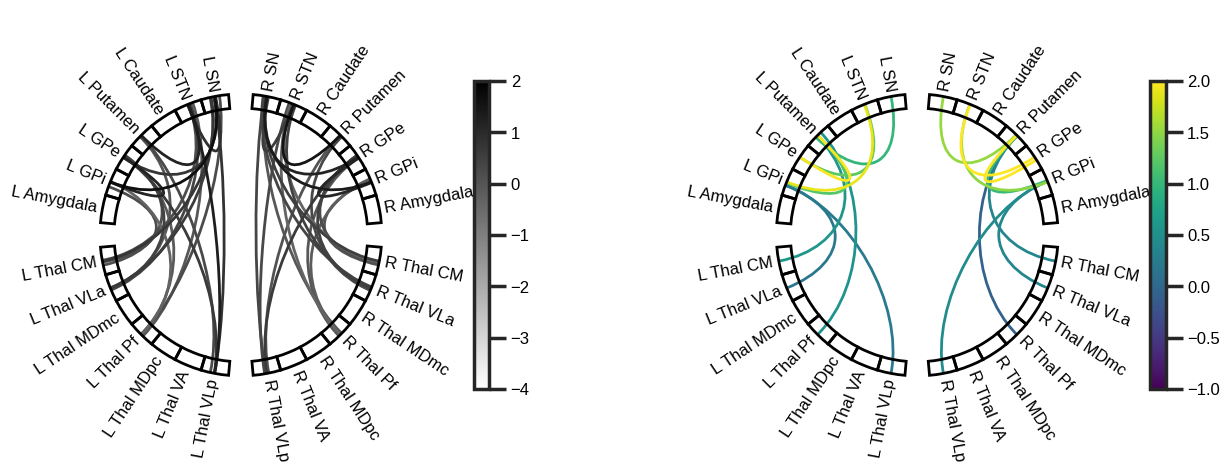

In [355]:
fig = plt.figure(figsize=(16, 8))

node_angles = circular_layout(final_node_names, final_node_names, start_pos=90,
                              group_boundaries=[0, 7, len(final_node_names) / 2, len(final_node_names) / 2 + 7])

# False connections
plot_chord(snsx_motortd_mat_fp, 
           final_node_names,
           node_angles=node_angles,
           fig=fig,
           subplot=(1,2,1),
           colorbar_pos=(-0.3, 0.5), 
           colorbar_size=.5, 
           fontsize_colorbar=12, 
           fontsize_names=12, 
           colormap="binary",
           vmin=-4, vmax=2, 
           facecolor="white", 
           textcolor="black",
           node_colors=[(0,0,0,0)],
           linewidth=2,
           show=False)

# True connections
plot_chord(snsx_motortd_mat_tp, 
           final_node_names,
           node_angles=node_angles,
           fig=fig, 
           subplot=(1,2,2),
           colorbar_pos=(-0.3, 0.5), 
           colorbar_size=.5, 
           fontsize_colorbar=12, 
           fontsize_names=12, 
           colormap=cmap,
           vmin=-1, vmax=2,
           facecolor="white", 
           textcolor="black",
           node_colors=[(0,0,0,0)],
           linewidth=2,
           show=False)

filename = "snsx_group_motor_circuit.svg"
fig.savefig(figure_dir.joinpath(filename), dpi=300, bbox_inches="tight", facecolor="white")

plt.show()
plt.close()

##### Associative Circuit

In [356]:
# Compute ROC curves
# Map nodes in left hemi (parc_map_idx, circuit_map_l_idx, circuit_map_r_idx
node_map = {"SN": (3, 0, 27), "STN": (5, 1, 26), "Caudate": (7, 2, 25), "Putamen": (9, 3, 24), 
            "GPe": (11, 4, 23), "GPi": (13, 5, 22), "Amygdala": (19, 6, 21), 
            "Thal CM": (26, 7, 20), "Thal VLa": (45, 8, 19), "Thal MDmc": (32, 9, 18), "Thal Pf": (36, 10, 17), 
            "Thal MDpc": (31, 11, 16), "Thal VA": (43, 12, 15), "Thal VLp": (46, 13, 14)}
l_node_names = [f"L {node}" for node in node_map.keys()]
r_node_names = [f"R {node}" for node in reversed(node_map.keys())]
final_node_names = l_node_names + r_node_names
del l_node_names, r_node_names


# TP connections 
assoc_conn = ["STN-GPe", "STN-GPi", "Caudate-GPe", "Caudate-GPi", "Putamen-GPe", "GPe-GPi", "GPi-Thal VA"]
assoc_idx = []
for conn in assoc_conn:
    node1, node2 = conn.split("-")
    assoc_idx.append((node_map[node1][1], node_map[node2][1]))
    assoc_idx.append((node_map[node1][2], node_map[node2][2]))
del node1, node2

# Get connectivity of all associate network nodes
all_assoc_l_conn, all_assoc_r_conn = [], []
all_assoc_l_idx, all_assoc_r_idx = [], []
assoc_all_nodes = ['STN', 'Caudate', 'Putamen', 'GPe', 'GPi', 'Thal VA']
for conn in itertools.combinations(assoc_all_nodes, 2):
    # Gap between left and right hemispheres for thalamus
    conn0_gap = 26 if "Thal" in conn[0] else 1
    conn1_gap = 26 if "Thal" in conn[1] else 1
    all_assoc_l_conn.append(f"{str(node_map[conn[0]][0])}-{str(node_map[conn[1]][0])}")
    all_assoc_l_idx.append((node_map[conn[0]][1], node_map[conn[1]][1]))
    all_assoc_r_conn.append(f"{str(node_map[conn[0]][0]+conn0_gap)}-{str(node_map[conn[1]][0]+conn1_gap)}")
    all_assoc_r_idx.append((node_map[conn[0]][2], node_map[conn[1]][2]))
all_assoc_conn = all_assoc_l_conn + all_assoc_r_conn
all_assoc_idx = all_assoc_l_idx + all_assoc_r_idx
del conn0_gap, conn1_gap, all_assoc_l_conn, all_assoc_r_conn, all_assoc_l_idx, all_assoc_r_idx
    
# Get TDs
snsx_assoc_td = np.asarray(
    [snsx_conn_df[snsx_conn_df["nodes"] == node]["tract density"].mean() for node in all_assoc_conn]
)

# Create all square matrix
snsx_assoctd_mat_fp = np.zeros((len(final_node_names), len(final_node_names)))
snsx_assoctd_mat_tp = snsx_assoctd_mat_fp.copy()
for j, idxes in enumerate(all_assoc_idx):
    if idxes in assoc_idx:
        snsx_assoctd_mat_tp[idxes[0], idxes[1]] = snsx_assoctd_mat_tp[idxes[1], idxes[0]] = np.log10(snsx_assoc_td[j])
    else:
        # Skip intrathalamic
        if (7 <= idxes[0] <= 13 and 7 <= idxes[1] <= 13) or (14 <= idxes[0] <= 20 and 14 <= idxes[1] <= 20):
            snsx_assoctd_mat_fp[idxes[0], idxes[1]] = snsx_assoctd_mat_fp[idxes[1], idxes[0]] = np.nan
        else:
            snsx_assoctd_mat_fp[idxes[0], idxes[1]] = snsx_assoctd_mat_fp[idxes[1], idxes[0]] = np.log10(snsx_assoc_td[j])

snsx_assoctd_mat_tp[snsx_assoctd_mat_tp == -np.inf] = np.nan
snsx_assoctd_mat_tp[snsx_assoctd_mat_tp == 0] = np.nan
snsx_assoctd_mat_fp[snsx_assoctd_mat_fp == -np.inf] = np.nan
snsx_assoctd_mat_fp[snsx_assoctd_mat_fp == 0] = np.nan

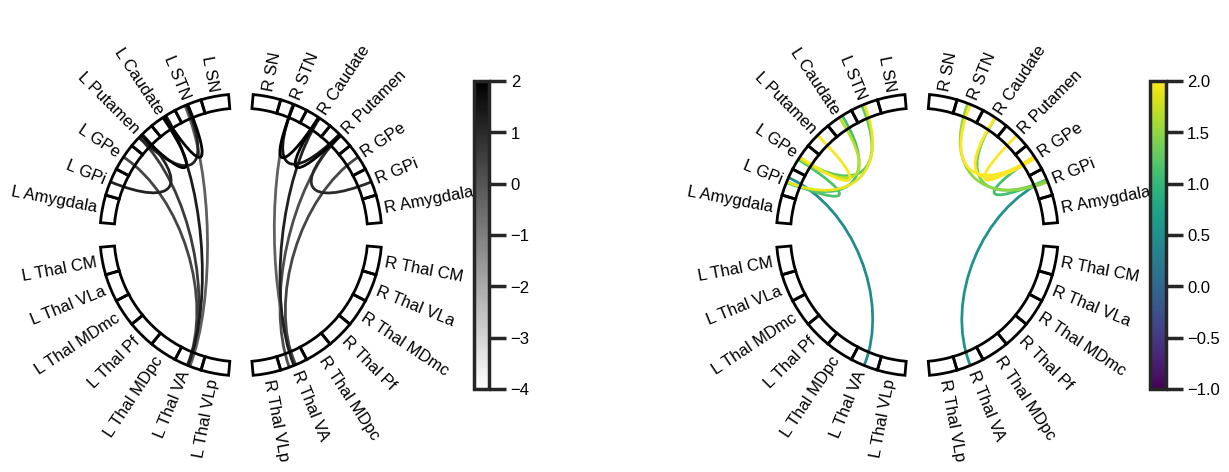

In [357]:
fig = plt.figure(figsize=(16, 8))

node_angles = circular_layout(final_node_names, final_node_names, start_pos=90,
                              group_boundaries=[0, 7, len(final_node_names) / 2, len(final_node_names) / 2 + 7])

# False connections
plot_chord(snsx_assoctd_mat_fp, 
           final_node_names,
           node_angles=node_angles,
           fig=fig,
           subplot=(1,2,1),
           colorbar_pos=(-0.3, 0.5), 
           colorbar_size=.5, 
           fontsize_colorbar=12, 
           fontsize_names=12, 
           colormap="binary",
           vmin=-4, vmax=2, 
           facecolor="white", 
           textcolor="black",
           node_colors=[(0,0,0,0)],
           linewidth=2,
           show=False)

# True connections
plot_chord(snsx_assoctd_mat_tp, 
           final_node_names,
           node_angles=node_angles,
           fig=fig, 
           subplot=(1,2,2),
           colorbar_pos=(-0.3, 0.5), 
           colorbar_size=.5, 
           fontsize_colorbar=12, 
           fontsize_names=12, 
           colormap=cmap,
           vmin=-1, vmax=2,
           facecolor="white", 
           textcolor="black",
           node_colors=[(0,0,0,0)],
           linewidth=2,
           show=False)

filename = "snsx_group_assoc_circuit.svg"
fig.savefig(figure_dir.joinpath(filename), dpi=300, bbox_inches="tight", facecolor="white")

plt.show()
plt.close()

##### Limbic Circuit

In [358]:
# Compute ROC curves
# Map nodes in left hemi (parc_map_idx, circuit_map_l_idx, circuit_map_r_idx
node_map = {"SN": (3, 0, 27), "STN": (5, 1, 26), "Caudate": (7, 2, 25), "Putamen": (9, 3, 24), 
            "GPe": (11, 4, 23), "GPi": (13, 5, 22), "Amygdala": (19, 6, 21), 
            "Thal CM": (26, 7, 20), "Thal VLa": (45, 8, 19), "Thal MDmc": (32, 9, 18), "Thal Pf": (36, 10, 17), 
            "Thal MDpc": (31, 11, 16), "Thal VA": (43, 12, 15), "Thal VLp": (46, 13, 14)}
l_node_names = [f"L {node}" for node in node_map.keys()]
r_node_names = [f"R {node}" for node in reversed(node_map.keys())]
final_node_names = l_node_names + r_node_names
del l_node_names, r_node_names


# TP connections 
limbic_conn = ["STN-GPe", "STN-GPi", "Caudate-Amygdala", "Putamen-GPi", "Putamen-Amygdala", "GPi-Thal MDmc", "GPi-Thal MDpc"]
limbic_idx = []
for conn in limbic_conn:
    node1, node2 = conn.split("-")
    limbic_idx.append((node_map[node1][1], node_map[node2][1]))
    limbic_idx.append((node_map[node1][2], node_map[node2][2]))
del node1, node2

# Get connectivity of all limbic network nodes
all_limbic_l_conn, all_limbic_r_conn = [], []
all_limbic_l_idx, all_limbic_r_idx = [], []
limbic_all_nodes = ['STN', 'Caudate', 'Putamen', 'GPe', 'GPi', 'Amygdala', 'Thal MDmc', 'Thal MDpc']
for conn in itertools.combinations(limbic_all_nodes, 2):
    conn0_gap = 26 if "Thal" in conn[0] else 1
    conn1_gap = 26 if "Thal" in conn[1] else 1
    all_limbic_l_conn.append(f"{str(node_map[conn[0]][0])}-{str(node_map[conn[1]][0])}")
    all_limbic_l_idx.append((node_map[conn[0]][1], node_map[conn[1]][1]))
    all_limbic_r_conn.append(f"{str(node_map[conn[0]][0]+conn0_gap)}-{str(node_map[conn[1]][0]+conn1_gap)}")
    all_limbic_r_idx.append((node_map[conn[0]][2], node_map[conn[1]][2]))
all_limbic_conn = all_limbic_l_conn + all_limbic_r_conn
all_limbic_idx = all_limbic_l_idx + all_limbic_r_idx
del conn0_gap, conn1_gap, all_limbic_l_conn, all_limbic_r_conn, all_limbic_l_idx, all_limbic_r_idx
    
# Get TDs
snsx_limbic_td = np.asarray(
    [snsx_conn_df[snsx_conn_df["nodes"] == node]["tract density"].mean() for node in all_limbic_conn]
)

# Create all square matrix
snsx_limbictd_mat_fp = np.zeros((len(final_node_names), len(final_node_names)))
snsx_limbictd_mat_tp = snsx_limbictd_mat_fp.copy()
for j, idxes in enumerate(all_limbic_idx):
    if idxes in limbic_idx:
        snsx_limbictd_mat_tp[idxes[0], idxes[1]] = snsx_limbictd_mat_tp[idxes[1], idxes[0]] = np.log10(snsx_limbic_td[j])
    else:
        # Skip intrathalamic
        if (7 <= idxes[0] <= 13 and 7 <= idxes[1] <= 13) or (14 <= idxes[0] <= 20 and 14 <= idxes[1] <= 20):
            snsx_limbictd_mat_fp[idxes[0], idxes[1]] = snsx_limbictd_mat_fp[idxes[1], idxes[0]] = np.nan
        else:
            snsx_limbictd_mat_fp[idxes[0], idxes[1]] = snsx_limbictd_mat_fp[idxes[1], idxes[0]] = np.log10(snsx_limbic_td[j])

snsx_limbictd_mat_tp[snsx_limbictd_mat_tp == -np.inf] = np.nan
snsx_limbictd_mat_tp[snsx_limbictd_mat_tp == 0] = np.nan
snsx_limbictd_mat_fp[snsx_limbictd_mat_fp == -np.inf] = np.nan
snsx_limbictd_mat_fp[snsx_limbictd_mat_fp == 0] = np.nan

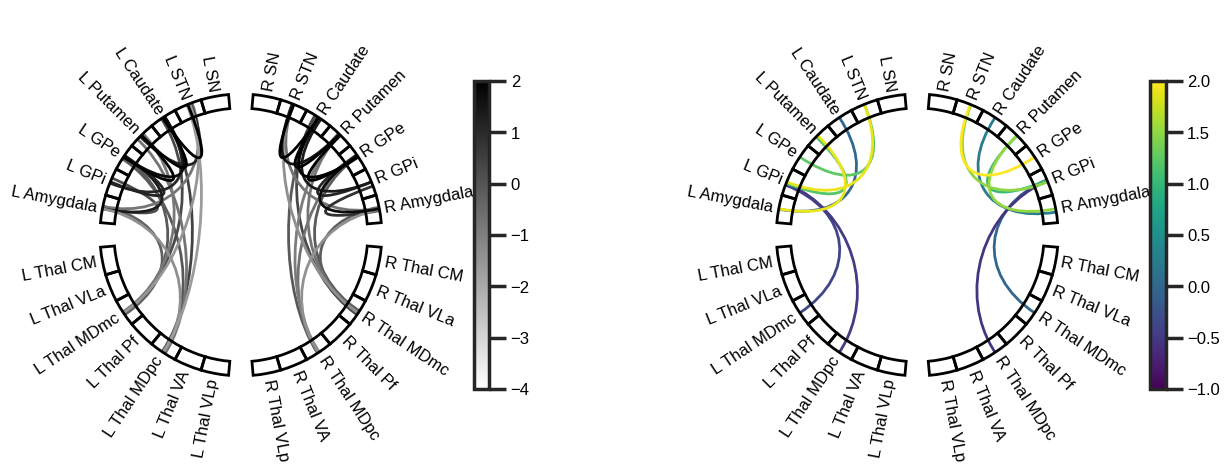

In [359]:
fig = plt.figure(figsize=(16, 8))

node_angles = circular_layout(final_node_names, final_node_names, start_pos=90,
                              group_boundaries=[0, 7, len(final_node_names) / 2, len(final_node_names) / 2 + 7])

# False connections
plot_chord(snsx_limbictd_mat_fp, 
           final_node_names,
           node_angles=node_angles,
           fig=fig,
           subplot=(1,2,1),
           colorbar_pos=(-0.3, 0.5), 
           colorbar_size=.5, 
           fontsize_colorbar=12, 
           fontsize_names=12, 
           colormap="binary",
           vmin=-4, vmax=2, 
           facecolor="white", 
           textcolor="black",
           node_colors=[(0,0,0,0)],
           linewidth=2,
           show=False)

# True connections
plot_chord(snsx_limbictd_mat_tp, 
           final_node_names,
           node_angles=node_angles,
           fig=fig, 
           subplot=(1,2,2),
           colorbar_pos=(-0.3, 0.5), 
           colorbar_size=.5, 
           fontsize_colorbar=12, 
           fontsize_names=12, 
           colormap=cmap,
           vmin=-1, vmax=2,
           facecolor="white", 
           textcolor="black",
           node_colors=[(0,0,0,0)],
           linewidth=2,
           show=False)

filename = "snsx_group_limbic_circuit.svg"
fig.savefig(figure_dir.joinpath(filename), dpi=300, bbox_inches="tight", facecolor="white")

plt.show()
plt.close()

### Dataset Comparison

#### HCP Test vs SNSX

In [405]:
# Whole matrix
hcptest_vs_snsx = stats.spearmanr(hcptest_avgconn_mat.flatten(), snsx_avgconn_mat.flatten(), nan_policy="omit")
print(f"Correlation between HCP Test (3T) and SNSX Controls (7T): \t\t\tr = {hcptest_vs_snsx[0]}, \tp = {hcptest_vs_snsx[1]}")

# Motor circuit
hcptest_vs_snsx_motor = stats.spearmanr(hcptest_motor_td, snsx_motor_td, nan_policy="omit")
print(f"Motor circuit correlation between HCP Test (3T) and SNSX Controls (7T): \tr = {hcptest_vs_snsx_motor[0]}, \tp = {hcptest_vs_snsx_motor[1]}")

# Assoc circuit
hcptest_vs_snsx_assoc = stats.spearmanr(hcptest_assoc_td, snsx_assoc_td, nan_policy="omit")
print(f"Associative circuit correlation between HCP Test (3T) and SNSX Controls (7T): \tr = {hcptest_vs_snsx_assoc[0]}, \tp = {hcptest_vs_snsx_assoc[1]}")

# Limbic circuit
hcptest_vs_snsx_limbic = stats.spearmanr(hcptest_limbic_td, snsx_limbic_td, nan_policy="omit")
print(f"Limbic circuit correlation between HCP Test (3T) and SNSX Controls (7T): \tr = {hcptest_vs_snsx_limbic[0]}, \tp = {hcptest_vs_snsx_limbic[1]}")


Correlation between HCP Test (3T) and SNSX Controls (7T): 			r = 0.8712722618480776, 	p = 0.0
Motor circuit correlation between HCP Test (3T) and SNSX Controls (7T): 	r = 0.8098504067885575, 	p = 2.0969132358601746e-17
Associative circuit correlation between HCP Test (3T) and SNSX Controls (7T): 	r = 0.7873192436040044, 	p = 2.44831408212018e-07
Limbic circuit correlation between HCP Test (3T) and SNSX Controls (7T): 	r = 0.8742138364779874, 	p = 6.0469635084834344e-18
